### Install Initial Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Load Dataset

This dataset contains over 8600 rows of data, on each row is a person’s:
- Type (This persons 4 letter MBTI code/type)
- A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

The dataset was taken from Kaggle, but the data itself was collected through the PersonalityCafe forum (http://personalitycafe.com/forum/). The purpose of this dataset is to help see if any patterns can be detected in specific types and their style of writing.

In [2]:
import os

CSV_DATA_PATH = os.path.join("data", "mbti_1.csv")

def load_csv_data(csv_file_path: str = CSV_DATA_PATH) -> pd.DataFrame:
    """ Load data from a given csv file into a pandas DataFrame object.

    Args:
    - csv_file_path (str) - The file path of the csv file containing the desired data to load into a pandas DataFrame object.

    Returns:
    - data (pandas.DataFrame) - The loaded data as a pandas DataFrame object.
    """
    assert csv_file_path.endswith(".csv")

    return pd.read_csv(csv_file_path)

In [3]:
data = load_csv_data()
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
# Quick check for duplicated rows
duplication_bool_series = data.duplicated()
duplication_bool_series.sum()

0

### Feature Importance

Using the newly engineered features, we will build a classifier using a tree-ensemble model like XGBoost and use its feature importance capability to get a sense of which features tend to be most important for determining the 4 axes of personality factors. The significance of these feature importances across the 4 axes of personality factors is, however, dependent on whether a satisfactory model can be fitted well to the given data.

For the classifiers to be trained, F1 score will be used as the scoring metric instead of accuracy. This is due to the class imbalances discovered in the data set during initial analysis. As F1 score is the harmonic mean of recall and precision, it takes both metrics into consideration. F1 score can be low as a result of low recall (which can happen in imbalanced data).

Stratified k-fold cross validation will also be used for training the classifiers as it enforces a particular ratio of classes for each split. This means that for each split, even if we do have an imbalanced data set, there will still be a particular proportion of classes belonging to the under-represented class for model training.

EDA will then be performed on the features that tend to be important in order to gain further insight as to how someone's writing style might relate to their MBTI personality type.

In [6]:
CSV_DATA_PATH = os.path.join("data", "mbti_2.csv")

df = load_csv_data(csv_file_path=CSV_DATA_PATH)
df.head()

,e_vs_i,s_vs_n,t_vs_f,j_vs_p,type,posts,url_count,posts_no_url,posts_no_url_tokenized,posts_no_url_pos_tagged,...,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq,negative_sentiment,neutral_sentiment,positive_sentiment,overall_sentiment,word_count
0,I,N,F,J,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,',"[""'""]","[(""'"", ""''"")]",...,0,0,0,0,0,0.00,1.00,0.0,0.0000,0
1,I,N,F,J,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,NaN,[],[],...,0,0,0,0,0,0.00,1.00,0.0,0.0000,0
2,I,N,F,J,INFJ,enfp and intj moments https://www.youtube.com...,2,enfp and intj moments sportscenter not top ...,"['enfp', 'and', 'intj', 'moments', 'sportscent...","[('enfp', 'NN'), ('and', 'CC'), ('intj', 'JJ')...",...,1,1,0,0,0,0.27,0.73,0.0,-0.4003,10
3,I,N,F,J,INFJ,What has been the most life-changing experienc...,0,What has been the most life-changing experienc...,"['what', 'has', 'been', 'the', 'most', 'life-c...","[('what', 'WDT'), ('has', 'VBZ'), ('been', 'VB...",...,1,1,1,0,2,0.00,1.00,0.0,0.0000,10
4,I,N,F,J,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,On repeat for most of today.,"['on', 'repeat', 'for', 'most', 'of', 'today',...","[('on', 'IN'), ('repeat', 'NN'), ('for', 'IN')...",...,1,0,3,0,0,0.00,1.00,0.0,0.0000,6


In [7]:
X = df[[
    "url_count",
    "noun_freq",
    "verb_freq",
    "cardinal_digits_freq",
    "adjective_freq",
    "adverb_freq",
    "preposition_freq",
    "interjection_freq",
    "determiner_freq",
    "overall_sentiment",
    "word_count"
]]
X.head()

,url_count,noun_freq,verb_freq,cardinal_digits_freq,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq,overall_sentiment,word_count
0,1,0,0,0,0,0,0,0,0,0.0000,0
1,1,0,0,0,0,0,0,0,0,0.0000,0
2,2,5,1,0,1,1,0,0,0,-0.4003,10
3,0,2,2,0,1,1,1,0,2,0.0000,10
4,2,2,0,0,1,0,3,0,0,0.0000,6


In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
targets = df[["e_vs_i", "s_vs_n", "t_vs_f", "j_vs_p"]].apply(label_encoder.fit_transform)
targets.head()

,e_vs_i,s_vs_n,t_vs_f,j_vs_p
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [9]:
df[["e_vs_i", "s_vs_n", "t_vs_f", "j_vs_p"]].head()

,e_vs_i,s_vs_n,t_vs_f,j_vs_p
0,I,N,F,J
1,I,N,F,J
2,I,N,F,J
3,I,N,F,J
4,I,N,F,J


##### Initial XGBoost Classifier for Extraversion vs Introversion

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y = targets["e_vs_i"].to_numpy()

xgboost_classifier_e_vs_i = XGBClassifier(eval_metric=f1_score, random_state=42)
xgboost_classifier_e_vs_i.fit(X, y)
y_pred = xgboost_classifier_e_vs_i.predict(X)
print(classification_report(y, y_pred, target_names=["Extraversion", "Introversion"]))

              precision    recall  f1-score   support

Extraversion       0.96      0.00      0.01     97582
Introversion       0.77      1.00      0.87    325263

    accuracy                           0.77    422845
   macro avg       0.86      0.50      0.44    422845
weighted avg       0.81      0.77      0.67    422845



In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgboost_classifier_e_vs_i, X, y, scoring="f1_macro")
mean_cv_score = np.mean(cv_scores)
print(f"Validation CV Macro F1 Scores: {cv_scores}")
print(f"Mean Validation CV Macro F1 Score: {mean_cv_score}")

Validation CV Macro F1 Scores: [0.43553382 0.43598057 0.43551852 0.43556097 0.43554912]
Mean Validation CV Macro F1 Score: 0.4356286006361202


##### Initial XGBoost Classifier for Intuition vs Sensing

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

y = targets["s_vs_n"].to_numpy()

xgboost_classifier_s_vs_n = XGBClassifier(eval_metric=f1_score, random_state=42)
xgboost_classifier_s_vs_n.fit(X, y)
y_pred = xgboost_classifier_s_vs_n.predict(X)
print(classification_report(y, y_pred, target_names=["Intuition", "Sensing"]))

              precision    recall  f1-score   support

   Intuition       0.86      1.00      0.93    364822
     Sensing       0.99      0.00      0.00     58023

    accuracy                           0.86    422845
   macro avg       0.93      0.50      0.47    422845
weighted avg       0.88      0.86      0.80    422845



In [13]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgboost_classifier_s_vs_n, X, y, scoring="f1_macro")
mean_cv_score = np.mean(cv_scores)
print(f"Validation CV Macro F1 Scores: {cv_scores}")
print(f"Mean Validation CV Macro F1 Score: {mean_cv_score}")

Validation CV Macro F1 Scores: [0.46322481 0.46314941 0.46312555 0.4634097  0.46347464]
Mean Validation CV Macro F1 Score: 0.4632768223870796


##### Initial XGBoost Classifier for Thinking vs Feeling

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

y = targets["t_vs_f"].to_numpy()

xgboost_classifier_t_vs_f = XGBClassifier(eval_metric=f1_score, random_state=42)
xgboost_classifier_t_vs_f.fit(X, y)
y_pred = xgboost_classifier_t_vs_f.predict(X)
print(classification_report(y, y_pred, target_names=["Feeling", "Thinking"]))

              precision    recall  f1-score   support

     Feeling       0.58      0.76      0.66    229312
    Thinking       0.56      0.35      0.43    193533

    accuracy                           0.58    422845
   macro avg       0.57      0.56      0.55    422845
weighted avg       0.57      0.58      0.56    422845



In [15]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgboost_classifier_t_vs_f, X, y, scoring="f1_macro")
mean_cv_score = np.mean(cv_scores)
print(f"Validation CV Macro F1 Scores: {cv_scores}")
print(f"Mean Validation CV Macro F1 Score: {mean_cv_score}")

Validation CV Macro F1 Scores: [0.52595853 0.52960918 0.52267723 0.52548048 0.52585923]
Mean Validation CV Macro F1 Score: 0.5259169280081107


##### Initial XGBoost Classifier for Judging vs Percieving

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

y = targets["j_vs_p"].to_numpy()

xgboost_classifier_j_vs_p = XGBClassifier(eval_metric=f1_score, random_state=42)
xgboost_classifier_j_vs_p.fit(X, y)
y_pred = xgboost_classifier_j_vs_p.predict(X)
print(classification_report(y, y_pred, target_names=["Judging", "Percieving"]))

              precision    recall  f1-score   support

     Judging       0.84      0.02      0.03    167110
  Percieving       0.61      1.00      0.76    255735

    accuracy                           0.61    422845
   macro avg       0.72      0.51      0.39    422845
weighted avg       0.70      0.61      0.47    422845



In [17]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgboost_classifier_j_vs_p, X, y, scoring="f1_macro")
mean_cv_score = np.mean(cv_scores)
print(f"Validation CV Macro F1 Scores: {cv_scores}")
print(f"Mean Validation CV Macro F1 Score: {mean_cv_score}")

Validation CV Macro F1 Scores: [0.38518657 0.38459218 0.3854913  0.38414562 0.38407729]
Mean Validation CV Macro F1 Score: 0.38469859256001027


#### SMOTE Oversampling

One of the observations from the initial classifiers fitted across the 4 axes of personality factors is that there tends to be low macro averaged F1 scores, which is caused by the class imbalances in the data. We focus here on macro averaged F1 scores since it weighs each class equally, which is helpful in situations where class imbalances are prevalent. 

One way to deal with this is to oversample the minority class before fitting the classifier so that the imbalance effect can be somewhat mitigated.

In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def build_classifier_with_smote(model=XGBClassifier(eval_metric=f1_score, random_state=42), sampling_strategy="auto"):
    """ Return the given model, with intitial SMOTE over-sampling.

    Args:
    - model - The classfication model to fit onto input data.
    - sampling_strategy - Sampling information to resample the data set. See API reference for imbalance-learn's SMOTE() for more details.

    Returns:
    - pipeline - A pipeline that oversamples fitted data using SMOTE and then proceeds to fit the input model onto the data being fed into the pipeline.
    """
    over_sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    pipeline = Pipeline([
        ("over_sampler", over_sampler),
        ("model", model)
    ])

    return pipeline    

##### XGBoost Classifier for Extraversion vs Introversion using SMOTE

In [19]:
y = targets["e_vs_i"].values

xgboost_classifier_e_vs_i = build_classifier_with_smote()
xgboost_classifier_e_vs_i.fit(X, y)
y_pred = xgboost_classifier_e_vs_i.predict(X)
print(classification_report(y, y_pred, target_names=["Extraversion", "Introversion"]))

              precision    recall  f1-score   support

Extraversion       0.27      0.34      0.30     97582
Introversion       0.78      0.72      0.75    325263

    accuracy                           0.63    422845
   macro avg       0.53      0.53      0.52    422845
weighted avg       0.67      0.63      0.65    422845



In [21]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgboost_classifier_e_vs_i, X, y, scoring="f1_macro")
mean_cv_score = np.mean(cv_scores)
print(f"Validation CV Macro F1 Scores: {cv_scores}")
print(f"Mean Validation CV Macro F1 Score: {mean_cv_score}")

Validation CV Macro F1 Scores: [0.50446481 0.50655233 0.50786471 0.51122627 0.50472538]
Mean Validation CV Macro F1 Score: 0.5069667000672048


##### XGBoost Classifier for Intuition vs Sensing using SMOTE

In [ ]:
y = targets["s_vs_n"].values

xgboost_classifier_s_vs_n = build_classifier_with_smote()
xgboost_classifier_s_vs_n.fit(X, y)
y_pred = xgboost_classifier_s_vs_n.predict(X)
print(classification_report(y, y_pred, target_names=["Intuition", "Sensing"]))

              precision    recall  f1-score   support

   Intuition       0.87      0.70      0.77    364822
     Sensing       0.16      0.35      0.22     58023

    accuracy                           0.65    422845
   macro avg       0.51      0.53      0.50    422845
weighted avg       0.77      0.65      0.70    422845



In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgboost_classifier_s_vs_n, X, y, scoring="f1_macro")
mean_cv_score = np.mean(cv_scores)
print(f"Validation CV Macro F1 Scores: {cv_scores}")
print(f"Mean Validation CV Macro F1 Score: {mean_cv_score}")

Validation CV Macro F1 Scores: [0.48286674 0.48030735 0.48182886 0.48182858 0.48090159]
Mean Validation CV Macro F1 Score: 0.4815466247681718


##### XGBoost Classifier for Thinking vs Feeling using SMOTE

In [ ]:
y = targets["t_vs_f"].values

xgboost_classifier_t_vs_f = build_classifier_with_smote()
xgboost_classifier_t_vs_f.fit(X, y)
y_pred = xgboost_classifier_t_vs_f.predict(X)
print(classification_report(y, y_pred, target_names=["Feeling", "Thinking"]))

              precision    recall  f1-score   support

     Feeling       0.61      0.55      0.58    229312
    Thinking       0.52      0.59      0.55    193533

    accuracy                           0.57    422845
   macro avg       0.57      0.57      0.57    422845
weighted avg       0.57      0.57      0.57    422845



In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgboost_classifier_t_vs_f, X, y, scoring="f1_macro")
mean_cv_score = np.mean(cv_scores)
print(f"Validation CV Macro F1 Scores: {cv_scores}")
print(f"Mean Validation CV Macro F1 Score: {mean_cv_score}")

Validation CV Macro F1 Scores: [0.54294513 0.54372997 0.54317304 0.54150478 0.54114781]
Mean Validation CV Macro F1 Score: 0.5425001485950848


##### XGBoost Classifier for Judging vs Perceiving using SMOTE

In [ ]:
y = targets["j_vs_p"].values

xgboost_classifier_j_vs_p = build_classifier_with_smote()
xgboost_classifier_j_vs_p.fit(X, y)
y_pred = xgboost_classifier_j_vs_p.predict(X)
print(classification_report(y, y_pred, target_names=["Judging", "Percieving"]))

              precision    recall  f1-score   support

     Judging       0.44      0.40      0.42    167110
  Percieving       0.63      0.67      0.65    255735

    accuracy                           0.56    422845
   macro avg       0.54      0.53      0.53    422845
weighted avg       0.56      0.56      0.56    422845



In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgboost_classifier_j_vs_p, X, y)
mean_cv_score = np.mean(cv_scores)
print(f"Validation CV Macro F1 Scores: {cv_scores}")
print(f"Mean Validation CV Macro F1 Score: {mean_cv_score}")

Validation CV Macro F1 Scores: [0.50344595 0.50521136 0.50303166 0.50099618 0.50374662]
Mean Validation CV Macro F1 Score: 0.5032863537090837


From performing some over-sampling of the data points within the minority classes, we can see some improvements to the F1 scores of the minority classes. We can also see some slight improvements to the macro averaged F1 scores for the classfiers. The authors of the original SMOTE research paper suggest combining soem undersampling techiques along side SMOTE for better performance, and so this will be tried out in the next section.

##### SMOTE + Edited Nearest Neighbors Undersampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def build_classifier_with_smote_enn(model=XGBClassifier(eval_metric=f1_score, random_state=42), sampling_strategy="auto"):
    """ Return the given model, with intitial SMOTE over-sampling.

    Args:
    - model - The classfication model to fit onto input data.
    - sampling_strategy - Sampling information to resample the data set. See API reference for imbalance-learn's SMOTE() for more details.

    Returns:
    - pipeline - A pipeline that oversamples fitted data using SMOTE and then proceeds to fit the input model onto the data being fed into the pipeline.
    """
    resampler = SMOTEENN(sampling_strategy=sampling_strategy, random_state=42)
    pipeline = Pipeline([
        ("resampler", resampler),
        ("model", model)
    ])

    return pipeline    

##### Extraversion vs Introversion

In [ ]:
from sklearn.metrics import classification_report

y = targets["e_vs_i"].values

xgboost_classifier_e_vs_i = build_classifier_with_smote_enn()
xgboost_classifier_e_vs_i.fit(X, y)
y_pred = xgboost_classifier_e_vs_i.predict(X)
print(classification_report(y, y_pred, target_names=["Extraversion", "Introversion"]))

              precision    recall  f1-score   support

Extraversion       0.25      0.68      0.36     97582
Introversion       0.80      0.38      0.52    325263

    accuracy                           0.45    422845
   macro avg       0.52      0.53      0.44    422845
weighted avg       0.67      0.45      0.48    422845



##### Intuition vs Sensing

In [ ]:
y = targets["s_vs_n"].values

xgboost_classifier_s_vs_n = build_classifier_with_smote_enn()
xgboost_classifier_s_vs_n.fit(X, y)
y_pred = xgboost_classifier_s_vs_n.predict(X)
print(classification_report(y, y_pred, target_names=["Intuition", "Sensing"]))

              precision    recall  f1-score   support

   Intuition       0.87      0.53      0.66    364822
     Sensing       0.15      0.51      0.23     58023

    accuracy                           0.53    422845
   macro avg       0.51      0.52      0.45    422845
weighted avg       0.77      0.53      0.60    422845



##### Feeling vs Thinking

In [ ]:
y = targets["t_vs_f"].values

xgboost_classifier_t_vs_f = build_classifier_with_smote_enn()
xgboost_classifier_t_vs_f.fit(X, y)
y_pred = xgboost_classifier_t_vs_f.predict(X)
print(classification_report(y, y_pred, target_names=["Feeling", "Thinking"]))

              precision    recall  f1-score   support

     Feeling       0.61      0.41      0.49    229312
    Thinking       0.50      0.69      0.58    193533

    accuracy                           0.54    422845
   macro avg       0.56      0.55      0.54    422845
weighted avg       0.56      0.54      0.53    422845



##### Judging vs Percieving

In [ ]:
y = targets["j_vs_p"].values

xgboost_classifier_j_vs_p = build_classifier_with_smote_enn()
xgboost_classifier_j_vs_p.fit(X, y)
y_pred = xgboost_classifier_j_vs_p.predict(X)
print(classification_report(y, y_pred, target_names=["Judging", "Percieving"]))

              precision    recall  f1-score   support

     Judging       0.41      0.75      0.53    167110
  Percieving       0.65      0.30      0.41    255735

    accuracy                           0.48    422845
   macro avg       0.53      0.52      0.47    422845
weighted avg       0.55      0.48      0.46    422845



We can see from the above results that while there is improvement in the F1 score of the minority classes, the majority classes F1 and the macro averaged F1 score were found to have gotten worse. Next, we shall try another method of SMOTE oversampling combined with undersampling.

##### SMOTE + Tomek Links

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def build_classifier_with_smote_tomek(model=XGBClassifier(eval_metric=f1_score, random_state=42), sampling_strategy="auto"):
    """ Return the given model, with intitial SMOTE over-sampling.

    Args:
    - model - The classfication model to fit onto input data.
    - sampling_strategy - Sampling information to resample the data set. See API reference for imbalance-learn's SMOTE() for more details.

    Returns:
    - pipeline - A pipeline that oversamples fitted data using SMOTE and then proceeds to fit the input model onto the data being fed into the pipeline.
    """
    resampler = SMOTETomek(sampling_strategy=sampling_strategy, random_state=42)
    pipeline = Pipeline([
        ("resampler", resampler),
        ("model", model)
    ])

    return pipeline    

##### Extraversion vs Introversion

In [ ]:
y = targets["e_vs_i"].values

xgboost_classifier_e_vs_i = build_classifier_with_smote_tomek()
xgboost_classifier_e_vs_i.fit(X, y)
y_pred = xgboost_classifier_e_vs_i.predict(X)
print(classification_report(y, y_pred, target_names=["Extraversion", "Introversion"]))

              precision    recall  f1-score   support

Extraversion       0.27      0.34      0.30     97582
Introversion       0.78      0.72      0.75    325263

    accuracy                           0.63    422845
   macro avg       0.53      0.53      0.52    422845
weighted avg       0.66      0.63      0.65    422845



##### Intuition vs Sensing

In [ ]:
y = targets["s_vs_n"].values

xgboost_classifier_s_vs_n = build_classifier_with_smote_tomek()
xgboost_classifier_s_vs_n.fit(X, y)
y_pred = xgboost_classifier_s_vs_n.predict(X)
print(classification_report(y, y_pred, target_names=["Intuition", "Sensing"]))

              precision    recall  f1-score   support

   Intuition       0.87      0.70      0.78    364822
     Sensing       0.16      0.35      0.22     58023

    accuracy                           0.65    422845
   macro avg       0.51      0.52      0.50    422845
weighted avg       0.77      0.65      0.70    422845



##### Feeling vs Thinking

In [ ]:
y = targets["t_vs_f"].values

xgboost_classifier_t_vs_f = build_classifier_with_smote_tomek()
xgboost_classifier_t_vs_f.fit(X, y)
y_pred = xgboost_classifier_t_vs_f.predict(X)
print(classification_report(y, y_pred, target_names=["Feeling", "Thinking"]))

              precision    recall  f1-score   support

     Feeling       0.61      0.56      0.58    229312
    Thinking       0.52      0.58      0.55    193533

    accuracy                           0.57    422845
   macro avg       0.57      0.57      0.57    422845
weighted avg       0.57      0.57      0.57    422845



##### Judging vs Percieving

In [ ]:
y = targets["j_vs_p"].values

xgboost_classifier_j_vs_p = build_classifier_with_smote_tomek()
xgboost_classifier_j_vs_p.fit(X, y)
y_pred = xgboost_classifier_j_vs_p.predict(X)
print(classification_report(y, y_pred, target_names=["Judging", "Percieving"]))

              precision    recall  f1-score   support

     Judging       0.44      0.40      0.42    167110
  Percieving       0.63      0.67      0.65    255735

    accuracy                           0.56    422845
   macro avg       0.53      0.53      0.53    422845
weighted avg       0.55      0.56      0.56    422845



The results obtained via using the default settings of Tomek Links along side SMOTE does not seem to improve model performance in terms of F1 scores of the classes and macro averaged F1 scores any more than just using SMOTE.

##### XGBoost + SMOTE Oversampling - Hyperparameter Tuning
In this section we will tune for the optimal hyperparameters for the classifiers using oversampled data via SMOTE. The tuning method will be a bayesian optimisation approach with 5-fold stratified cross validation.

In [42]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Integer

param_space = {
    'max_depth': Integer(3, 18),
    'learning_rate': Real(0.01, 1.0, prior="log-uniform"),
    'colsample_bytree': Real(0.5, 1.0),
    'colsample_bylevel': Real(0.5, 1.0),
    'n_estimators': Integer(100, 700)
}

def xgbclassifier_binary_cv(X, y, estimator=XGBClassifier(random_state=42), param_space=param_space, random_state=42, n_iter=10, cv=StratifiedKFold(shuffle=True), scoring="f1_macro"):
    """XGBoost Classifier Model and using bayesian optimisation for hyperparameter tuning.

    Args:
    - X - The feature data.
    - y - The target variable.
    - param_space - The parameter space in which to randomly experiment with different hyperparameters when performing stratified k-fold cross validation for training the classifier.
    - random_state - Random seed for consistent results when comparing.
    - n_iter - Number of iterations for BayesSearchCV.
    - cv - Type of k fold cross validation to use.
    - scoring - The evaluation metric to use for scoring.

    Returns:
    - model - The fitted model with the tuned hyperparameters.
    """
    model = BayesSearchCV(
        estimator=estimator,
        search_spaces=param_space,
        cv=cv,
        scoring=scoring,
        random_state=random_state,
        n_iter=n_iter,
        return_train_score=True
    )

    model.fit(X, y)

    return model

Extraversion vs Introversion

In [11]:
y = targets["e_vs_i"].values

over_sampler = SMOTE(random_state=42)
X_res, y_res = over_sampler.fit_resample(X, y)

In [18]:
xgboost_classifier_e_vs_i = xgbclassifier_binary_cv(X_res, y_res)
y_pred = xgboost_classifier_e_vs_i.predict(X)
print(classification_report(y, y_pred, target_names=["Extraversion", "Introversion"]))

              precision    recall  f1-score   support

Extraversion       0.70      0.68      0.69     97582
Introversion       0.91      0.91      0.91    325263

    accuracy                           0.86    422845
   macro avg       0.80      0.80      0.80    422845
weighted avg       0.86      0.86      0.86    422845



In [29]:
best_params = xgboost_classifier_e_vs_i.best_params_
test_score = xgboost_classifier_e_vs_i.best_score_
print(f"Best params: {best_params}")
print(f"Test score: {test_score}")

Best params: OrderedDict([('colsample_bylevel', 0.9186941777766422), ('colsample_bytree', 0.9416576386904312), ('learning_rate', 0.04044084484117812), ('max_depth', 17), ('n_estimators', 618)])
Test score: 0.7578001257713494


In [30]:
# Note that these results are based on the oversampled dataset.
results = pd.concat([
    pd.DataFrame(xgboost_classifier_e_vs_i.cv_results_["mean_test_score"], columns=["mean_test_score"]),
    pd.DataFrame(xgboost_classifier_e_vs_i.cv_results_["std_test_score"], columns=["std_test_score"]),
    pd.DataFrame(xgboost_classifier_e_vs_i.cv_results_["mean_train_score"], columns=["mean_train_score"]),
    pd.DataFrame(xgboost_classifier_e_vs_i.cv_results_["std_train_score"], columns=["std_train_score"])
], axis=1)
results

,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.723350,0.000668,0.815098,0.000600
1,0.757800,0.001745,0.896635,0.000688
2,0.629062,0.000483,0.640946,0.000677
3,0.750696,0.001187,0.884116,0.000916
4,0.752795,0.001333,0.874417,0.000282
5,0.631425,0.000925,0.640396,0.000747
6,0.753315,0.001255,0.880091,0.000451
7,0.747528,0.001229,0.882107,0.000870
8,0.729722,0.001597,0.808439,0.000648
9,0.712722,0.000864,0.747794,0.000927


Based on the classification report on the original data, the recall and the F1-score of the minority class (Extraversion) has siginificantly improve. Ths precision and recall of the majority class (Introversion) has also seen some significant improvements. Overall, these improvements have led to an increase in the macro averaged F1-score. 

However, based on the cross validation results on the ovesamples data, there might be signs of overfitting for the best model (index 1). To deal with this, regularization hyperparameters can also be tuned, but for now we shall leave it as the goal here is to a "good enough" model to gain insights into what features could be important to relating online user posts/comments with MBTI personality types.

In [51]:
# Save optimal classifier locally
xgboost_classifier_e_vs_i.best_estimator_.save_model("models/e_vs_i_opt.json")

Intuition vs Sensing

In [39]:
y = targets["s_vs_n"].values

over_sampler = SMOTE(random_state=42)
X_res, y_res = over_sampler.fit_resample(X, y)

In [ ]:
xgboost_classifier_s_vs_n = xgbclassifier_binary_cv(X_res, y_res)

In [46]:
y_pred = xgboost_classifier_s_vs_n.predict(X)
print(classification_report(y, y_pred, target_names=["Intuition", "Sensing"]))

              precision    recall  f1-score   support

   Intuition       0.94      0.88      0.91    364822
     Sensing       0.47      0.66      0.55     58023

    accuracy                           0.85    422845
   macro avg       0.71      0.77      0.73    422845
weighted avg       0.88      0.85      0.86    422845



In [47]:
best_params = xgboost_classifier_s_vs_n.best_params_
test_score = xgboost_classifier_s_vs_n.best_score_
print(f"Best params: {best_params}")
print(f"Test score: {test_score}")

Best params: OrderedDict([('colsample_bylevel', 0.9186941777766422), ('colsample_bytree', 0.9416576386904312), ('learning_rate', 0.04044084484117812), ('max_depth', 17), ('n_estimators', 618)])
Test score: 0.8245835428069688


In [48]:
# Note that these results are based on the oversampled dataset.
results = pd.concat([
    pd.DataFrame(xgboost_classifier_s_vs_n.cv_results_["mean_test_score"], columns=["mean_test_score"]),
    pd.DataFrame(xgboost_classifier_s_vs_n.cv_results_["std_test_score"], columns=["std_test_score"]),
    pd.DataFrame(xgboost_classifier_s_vs_n.cv_results_["mean_train_score"], columns=["mean_train_score"]),
    pd.DataFrame(xgboost_classifier_s_vs_n.cv_results_["std_train_score"], columns=["std_train_score"])
], axis=1)
results

,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.786403,0.000599,0.849712,0.000482
1,0.824584,0.000455,0.907778,0.000742
2,0.654872,0.000534,0.663971,0.000803
3,0.818766,0.000623,0.903330,0.000466
4,0.819506,0.000546,0.895534,0.000635
5,0.654426,0.001071,0.660039,0.000737
6,0.818414,0.000841,0.895325,0.000250
7,0.813402,0.001279,0.894831,0.000579
8,0.791094,0.000767,0.843384,0.001025
9,0.762942,0.000697,0.787400,0.000540


Here, we also see that the precision, recall and F1-score of the both minority and majority classes have significantly increased. There is more confidence here with using the optimised classifier for intuiition vs sensing to gain insights on which features are important in determining this particular axis of personality factors.

In [52]:
# Save optimal classifier locally
xgboost_classifier_s_vs_n.best_estimator_.save_model("models/s_vs_n_opt.json")

Feeling vs Thinking

In [49]:
y = targets["t_vs_f"].values

over_sampler = SMOTE(random_state=42)
X_res, y_res = over_sampler.fit_resample(X, y)

In [ ]:
xgboost_classifier_t_vs_f = xgbclassifier_binary_cv(X_res, y_res)

In [ ]:
y_pred = xgboost_classifier_t_vs_f.predict(X)
print(classification_report(y, y_pred, target_names=["Intuition", "Sensing"]))

In [ ]:
best_params = xgboost_classifier_t_vs_f.best_params_
test_score = xgboost_classifier_t_vs_f.best_score_
print(f"Best params: {best_params}")
print(f"Test score: {test_score}")

In [ ]:
# Note that these results are based on the oversampled dataset.
results = pd.concat([
    pd.DataFrame(xgboost_classifier_t_vs_f.cv_results_["mean_test_score"], columns=["mean_test_score"]),
    pd.DataFrame(xgboost_classifier_t_vs_f.cv_results_["std_test_score"], columns=["std_test_score"]),
    pd.DataFrame(xgboost_classifier_t_vs_f.cv_results_["mean_train_score"], columns=["mean_train_score"]),
    pd.DataFrame(xgboost_classifier_t_vs_f.cv_results_["std_train_score"], columns=["std_train_score"])
], axis=1)
results

In [ ]:
# Save optimal classifier locally
xgboost_classifier_t_vs_f.best_estimator_.save_model("models/s_vs_n_opt.json")

##### XGBoost + SMOTE Oversampling - Feature Importance

The below graphs will show the most important features for relating a user's online comments/posts to their Myers-Briggs personality types. Out of the classifiers experimented with above, SMOTE oversampling will be used as it yielded better results in terms of F1 score.

In [12]:
y = targets["e_vs_i"].values

xgboost_classifier_e_vs_i = build_classifier_with_smote()
xgboost_classifier_e_vs_i.fit(X, y)

Pipeline(steps=[('over_sampler', SMOTE(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               eval_metric=<function f1_score at 0x000001A1B53C7AC0>,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [13]:
y = targets["s_vs_n"].values

xgboost_classifier_s_vs_n = build_classifier_with_smote()
xgboost_classifier_s_vs_n.fit(X, y)

Pipeline(steps=[('over_sampler', SMOTE(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               eval_metric=<function f1_score at 0x000001A1B53C7AC0>,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [14]:
y = targets["t_vs_f"].values

xgboost_classifier_t_vs_f = build_classifier_with_smote()
xgboost_classifier_t_vs_f.fit(X, y)

Pipeline(steps=[('over_sampler', SMOTE(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               eval_metric=<function f1_score at 0x000001A1B53C7AC0>,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [15]:
y = targets["j_vs_p"].values

xgboost_classifier_j_vs_p = build_classifier_with_smote()
xgboost_classifier_j_vs_p.fit(X, y)

Pipeline(steps=[('over_sampler', SMOTE(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               eval_metric=<function f1_score at 0x000001A1B53C7AC0>,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

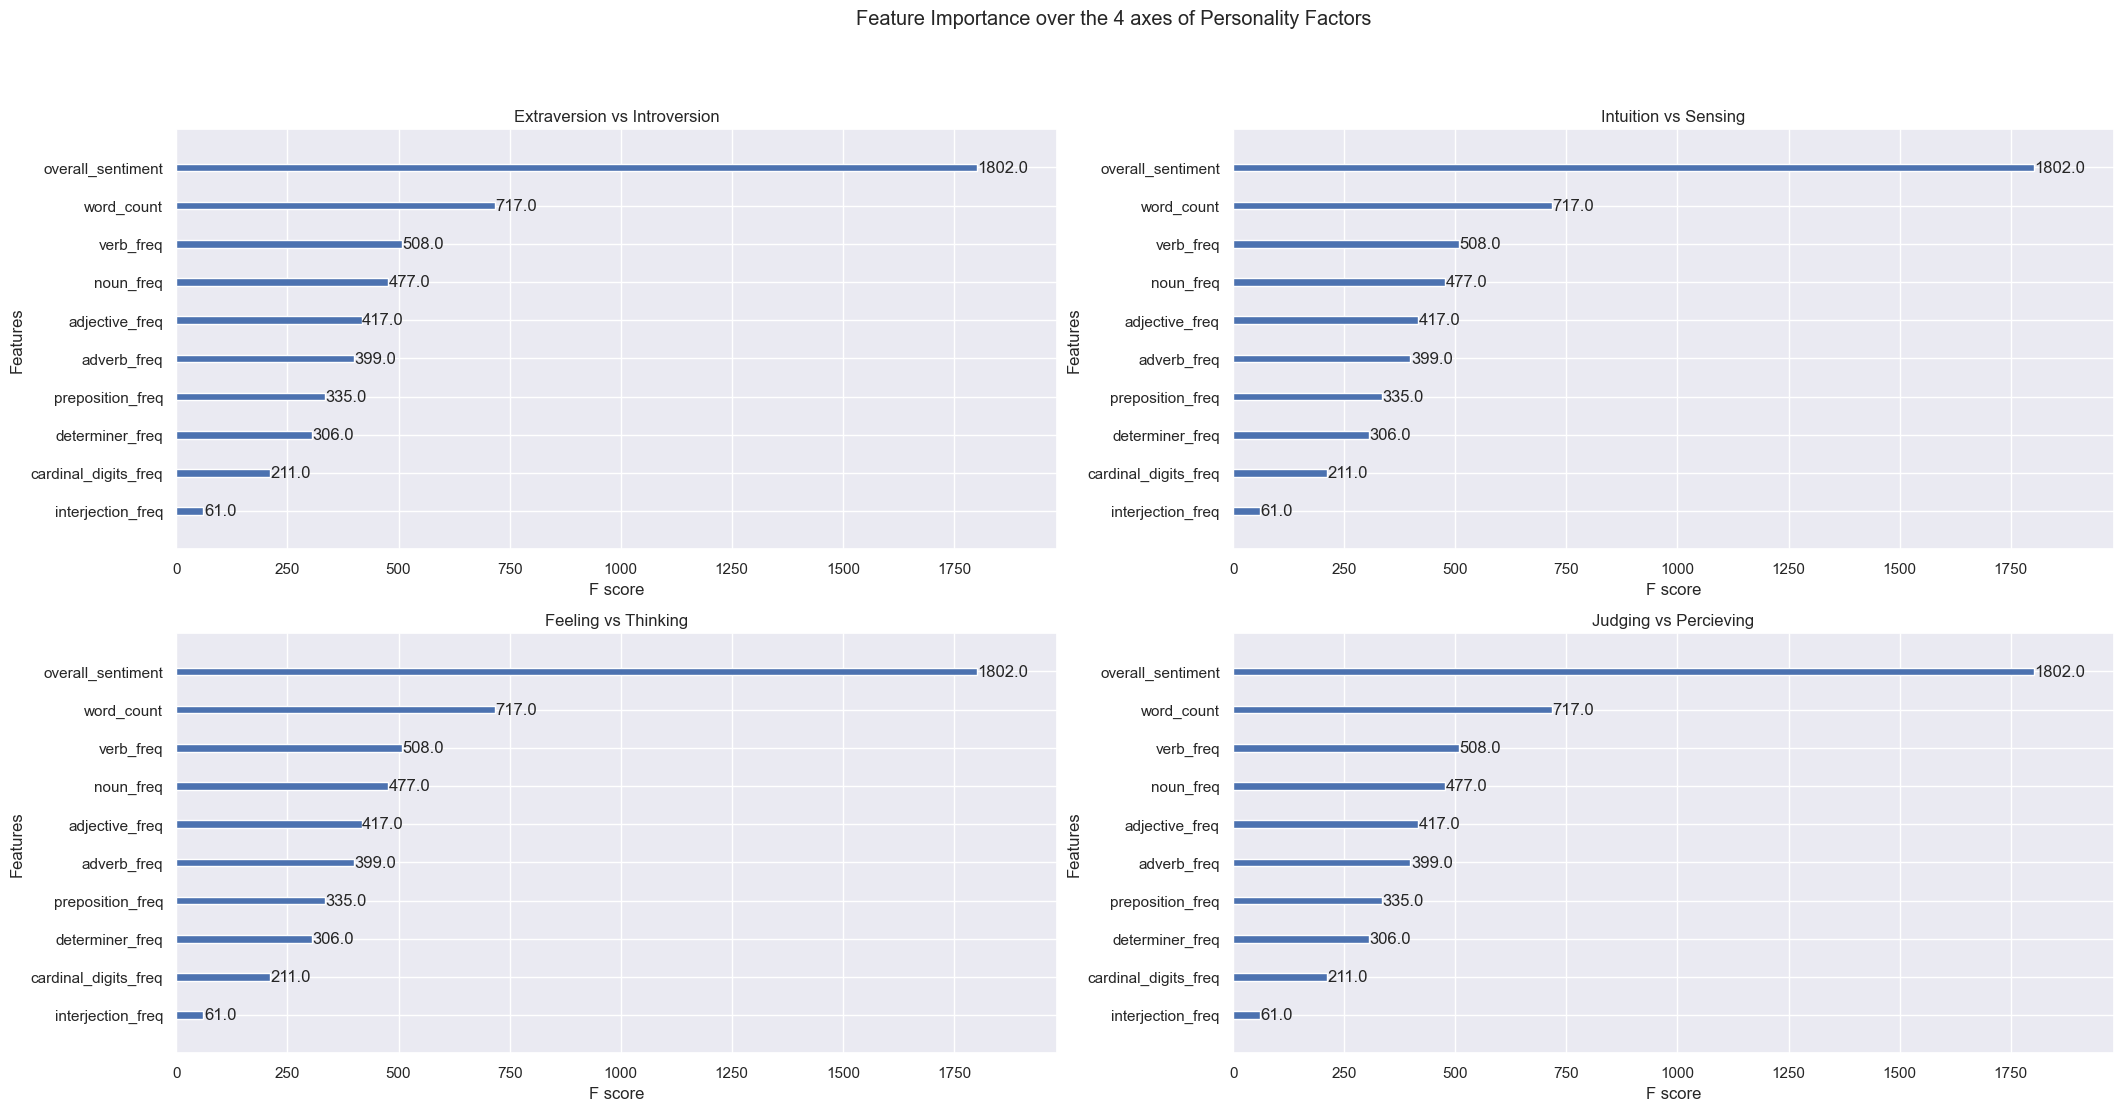

In [16]:
from xgboost import plot_importance

sns.set()

fig, axes = plt.subplots(2, 2, figsize=(25,12))
axes = axes.flatten()

plot_importance(booster=xgboost_classifier_e_vs_i.named_steps["model"], ax=axes[0], max_num_features=10, title="Extraversion vs Introversion")
plot_importance(booster=xgboost_classifier_s_vs_n.named_steps["model"], ax=axes[1], max_num_features=10, title="Intuition vs Sensing")
plot_importance(booster=xgboost_classifier_t_vs_f.named_steps["model"], ax=axes[2], max_num_features=10, title="Feeling vs Thinking")
plot_importance(booster=xgboost_classifier_j_vs_p.named_steps["model"], ax=axes[3], max_num_features=10, title="Judging vs Percieving")

fig.suptitle("Feature Importance over the 4 axes of Personality Factors")

plt.show()

From the above plots of feature importances across the 4 axes of personality factors, we can observe that the most important feature in terms of improvements in accuracy brought to the branches of the decison trees the models are made up of is the overall sentiment of a post/comment. According to the models, by a large margin, whether a online comment/post's sentiment is postive, negative or neutral tends to contribute the most in determining the user's Myers-Briggs personality factors.

Word length of a user's online post/comment has also been observed to be a more important contribution than some of the other features when infering the user's personlaity factors.

Although the accuracy performance of these models tend to be better than randomly guessing, it should be noted that given how these models fit the data and their F1 scores, the significance of the insights that can be drawn from the above (relating to which factors could be important in inferring Myers-Briggs personality factors) should be taken with a grain of salt.